## Customer Age Prediction from Photos 

This is a project for a liquor store in which we will attempt to build a machine learning model to predict customer age based on photos. We will start by loading and processing datasets, performing EDA, and then beginning to train our models. We will then run our model on a GPU to boost performance and analyze the results. Our aim is to see if we can use historical images to train the model to correctly detect the age of a customer. 

## Load Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

final_files file contains all 7.6k photos
labels.csv file contains labels, with two columns: file_name and real_age

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
print(f'Dataset size: {df.shape[0]} samples')
df.head()

Dataset size: 7591 samples


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

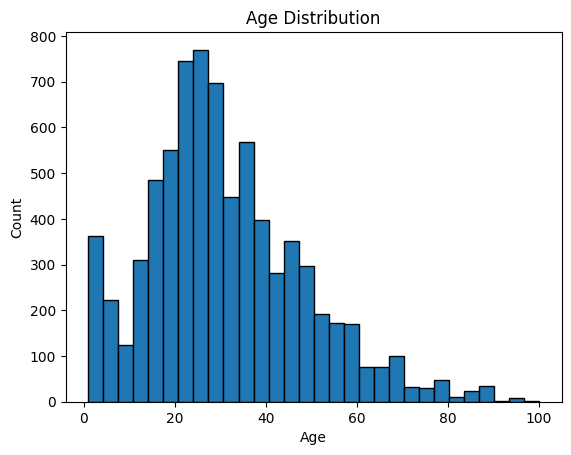

In [3]:
plt.hist(df['real_age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Photos')
plt.show()

Here we can see the most common age group is early 20's, with age steadily declining from there. There is also a small spike in early ages indicicated some toddlers or small children. Aside from the early spike the data seems to adhere to a normal distribition bell curve. 

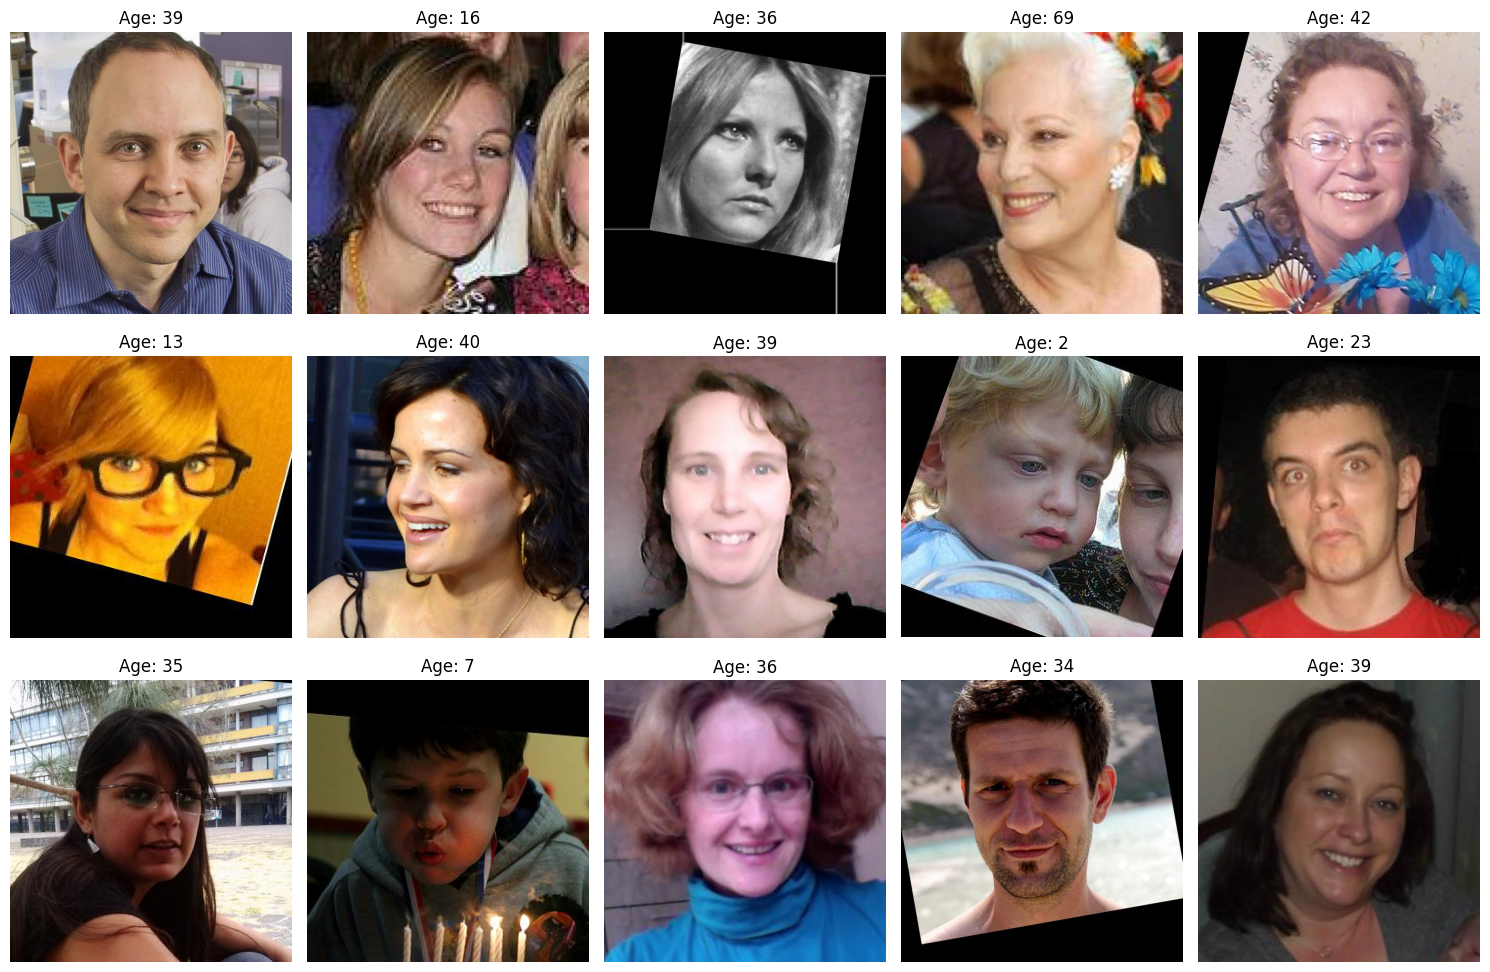

In [4]:
sample_df = df.sample(15)
plt.figure(figsize=(15, 10))

for idx, row in enumerate(sample_df.itertuples()):
    img_path = os.path.join('/datasets/faces/final_files', row.file_name)
    image = mpimg.imread(img_path)
    plt.subplot(3, 5, idx + 1)
    plt.imshow(image)
    plt.title(f'Age: {int(row.real_age)}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Findings

We can see some potential issues which might occur when training our mode. Some of the images need to be rotated, some need contrast and brightness adjusted, and some are color while others are black and white. 

## Modelling

Here we will define the necessary functions to train the model on the GPU platform and build a single script containing all of them along with the initialization section.


In [6]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    df = pd.read_csv(path + 'labels.csv')
    df['file_name'] = path + 'final_files/' + df['file_name']

    datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        brightness_range=(0.8, 1.2)
    )

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=None,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',  
        subset='training',
        seed=42
    )

    return train_gen_flow

In [7]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    df = pd.read_csv(path + 'labels.csv')
    df['file_name'] = path + 'final_files/' + df['file_name']

    datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255
    )

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=None,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )

    return test_gen_flow

In [8]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1)  
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

## Prepare the Script to Run on the GPU Platform

Here we prepare a script to run on Google Colab to leverage their high performance GPU. 

In [10]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

The output from the GPU platform is listed below 

"""
Found 6073 validated image filenames.
Found 1518 validated image filenames.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()

Epoch 1/20
190/190 - 116s - 610ms/step - loss: 728.6251 - mae: 21.4079 - val_loss: 296.9598 - val_mae: 12.9514

Epoch 2/20
190/190 - 89s - 468ms/step - loss: 308.7119 - mae: 13.4201 - val_loss: 292.2779 - 
val_mae: 13.6675

Epoch 3/20
190/190 - 143s - 751ms/step - loss: 303.3391 - mae: 13.4800 - val_loss: 290.1715 - val_mae: 13.5434

Epoch 4/20
190/190 - 90s - 473ms/step - loss: 302.3831 - mae: 13.4550 - val_loss: 291.2974 - val_mae: 13.6137

Epoch 5/20
190/190 - 89s - 470ms/step - loss: 305.2888 - mae: 13.4758 - val_loss: 289.5139 - val_mae: 13.5031

Epoch 6/20
190/190 - 90s - 476ms/step - loss: 302.9441 - mae: 13.4355 - val_loss: 289.2679 - val_mae: 13.4884

Epoch 7/20
190/190 - 89s - 469ms/step - loss: 303.1291 - mae: 13.4624 - val_loss: 290.3015 - val_mae: 13.5594

Epoch 8/20
190/190 - 90s - 474ms/step - loss: 301.7236 - mae: 13.4748 - val_loss: 287.6050 - val_mae: 13.3674

Epoch 9/20
190/190 - 90s - 475ms/step - loss: 304.7162 - mae: 13.4538 - val_loss: 291.5053 - val_mae: 13.6338

Epoch 10/20
190/190 - 89s - 470ms/step - loss: 304.1888 - mae: 13.4554 - val_loss: 288.2721 - val_mae: 13.4302

Epoch 11/20
190/190 - 90s - 473ms/step - loss: 304.8278 - mae: 13.4962 - val_loss: 290.6008 - val_mae: 13.5862

Epoch 12/20
190/190 - 90s - 473ms/step - loss: 302.9455 - mae: 13.5223 - val_loss: 286.5394 - val_mae: 13.2843

Epoch 13/20
190/190 - 90s - 473ms/step - loss: 301.6693 - mae: 13.4084 - val_loss: 289.3771 - val_mae: 13.5150

Epoch 14/20
190/190 - 89s - 468ms/step - loss: 302.3655 - mae: 13.4547 - val_loss: 289.2407 - val_mae: 13.5084

Epoch 15/20
190/190 - 90s - 473ms/step - loss: 303.9726 - mae: 13.4703 - val_loss: 287.7794 - val_mae: 13.4092

Epoch 16/20
190/190 - 90s - 472ms/step - loss: 302.7795 - mae: 13.4418 - val_loss: 288.8645 - val_mae: 13.4884

Epoch 17/20
190/190 - 89s - 470ms/step - loss: 302.1746 - mae: 13.3992 - val_loss: 289.4353 - val_mae: 13.5282

Epoch 18/20
190/190 - 91s - 479ms/step - loss: 301.7395 - mae: 13.4262 - val_loss: 288.7516 - val_mae: 13.4864

Epoch 19/20
190/190 - 89s - 471ms/step - loss: 301.5363 - mae: 13.4294 - val_loss: 290.6888 - val_mae: 13.6058

Epoch 20/20
190/190 - 90s - 474ms/step - loss: 301.1534 - mae: 13.3908 - val_loss: 290.0674 - val_mae: 13.5723
"""

## Conclusions

Here we can see the val and training results are similar, so the model is not overfitting, but the scores are not improving much with more epochs so there is no need to increase. The model on average is about 13 years off of the actual age, so it may still be somewhat useful in this case but will not be exactly accurate. Practically, the model can still decide for certain cases where the customer is clearly above the age limit, such as someone 34 yrs and older. 

If we want to try and improve the performance there are some options we can try. We could try normalization since there is a wide range of ages, we could also modify augmentation to improve generalization, and also we could try different models which might outperform ResNet50. 